<a href="https://colab.research.google.com/github/mishathefirst/InfSecurity/blob/main/Task_6_P_Students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание
В этом задании мы рассмотрим пример применения зловредного обучения. На первом этапе мы обучим нейронную сеть классифицировать изображения в зависимости от того, что изображено. Далее мы будем моделировать различные атаки и анализировать то, насколько хуже нейронная стала справляться со своей задачей.

## Установка библиотеки Adversarial Robustness Toolbox (ART)
Библиотека предназначена для решения задач информационной безопасности и машинного обучения. ART предоставляет инструменты, которые позволяют разработчикам и исследователям защищать и оценивать модели и приложения машинного обучения от враждебных угроз: Evasion, Poisoning, Extraction и Inference.

In [ ]:
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 890kB 9.5MB/s 
     |████████████████████████████████| 235kB 21.4MB/s 
     |████████████████████████████████| 21.0MB 10.6MB/s 
     |████████████████████████████████| 747kB 40.1MB/s 


## Импорт библиотек

In [ ]:
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')
tf.compat.v1.disable_eager_execution()
from matplotlib import pyplot as plt
from art.classifiers import KerasClassifier
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod
from art.attacks.evasion import DeepFool, SaliencyMapMethod, ProjectedGradientDescent,PixelAttack
import keras
import time

Нам также потребуется библиотека для решения оптимизационных задач, а именно алгоритм стохастической численной оптимизации для сложных (невыпуклых, плохо обусловленных, мультимодальных, сложных, шумных) задач оптимизации в непрерывных пространствах.

In [ ]:
!pip install cma

In [ ]:
from tensorflow import keras

In [ ]:
from keras.models import Sequential
from art.config import ART_DATA_PATH
from art.classifiers import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescent
from art.utils import get_file
from keras.models import load_model

## Загрузка датасета и обучение нейронной сети
В качестве датасета будем использовать CIFAR10.
Набор данных CIFAR-10 состоит из 60000 цветных изображений размером 32x32 пикселей, каждое из которых отнесено к одному из 10 классов, по 6000 изображений на класс. Имеется 50000 обучающих изображений и 10000 тестовых изображений. Мы выберем только 10000 обучающих и 2000 тестовых объектов.

In [ ]:
(x_train, y_train), (x_test, y_test)  = tf.keras.datasets.cifar10.load_data()
X_train = x_train[:10000]
X_test = x_test[:2000]
Y_train = y_train[:10000]
Y_test = y_test[:2000]

Нормируем признаки в пределах от 0 до 1 и зададим более "понятные" метки классов

In [ ]:
#print(tf.compat.v1.get_default_graph()._last_id)
X_train = X_train/255
X_test = X_test/255
classes_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Выведем на экран первый тернировочный объект. Можно догадаться, что изображение относится к классу frog.

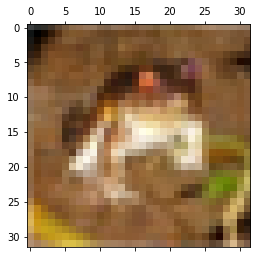

In [ ]:
from matplotlib import pyplot as plt
plt.matshow(X_train[0])
plt.show()

В следующем блоке устанавливаются начальные значения генераторов случайных чисел и принудительно отключается параллелизм потоков процессов. Иначе получаемые значения при каждом запуске скорее всего будут отличаться. Блок нужен исключительно в целях воспроизводимости результатов и проверки заданий. В других случаях этот блок можно игнорировать, т.к. он значительно снижает производительность.
____________________________________________


In [ ]:
import numpy as np
import tensorflow as tf
import random as rn
import os
def refresh():
  os.environ['PYTHONHASHSEED']=str(1)
  np.random.seed(1)
  rn.seed(1)
  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                          inter_op_parallelism_threads=1)
  tf.compat.v1.set_random_seed(1)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
  tf.compat.v1.keras.backend.set_session(sess)
  tf.compat.v1.disable_eager_execution()
  #print(tf.compat.v1.get_default_graph()._last_id)

Настраиваем модель нейронной сети, которая будет обучаться

In [ ]:
refresh() # сброс настроек


model = 0
seed = 1
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape = [32, 32, 3], kernel_initializer=keras.initializers.glorot_uniform(seed)))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed)))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2, padding='valid'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units = 128, activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed)))
model.add(tf.keras.layers.Dense(units=10, activation='softmax', kernel_initializer=keras.initializers.glorot_uniform(seed)))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

Обучаем модель на тренировочных данных (5 эпох). Наберитесь терпения, это займет какое-то время.
_________________________________________

In [ ]:
te=time.time() 

model.fit(X_train, Y_train, epochs = 5,validation_data=(X_test, Y_test))
vrem0=time.time() -te

Train on 10000 samples, validate on 2000 samples
Epoch 1/5
10000/10000 [==============================] - ETA: 0s - loss: 1.7367 - accuracy: 0.3709WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
10000/10000 [==============================] - 38s 4ms/sample - loss: 1.7367 - accuracy: 0.3709 - val_loss: 1.4922 - val_accuracy: 0.4640
Epoch 2/5
10000/10000 [==============================] - 38s 4ms/sample - loss: 1.3481 - accuracy: 0.5212 - val_loss: 1.3142 - val_accuracy: 0.5310
Epoch 3/5
10000/10000 [==============================] - 38s 4ms/sample - loss: 1.1615 - accuracy: 0.5885 - val_loss: 1.2132 - val_accuracy: 0.5710
Epoch 4/5
10000/10000 [==============================] - 38s 4ms/

In [ ]:
import datetime

In [ ]:
print("TIME",vrem0)
print('Сompleted in',datetime.datetime.now().time())

TIME 190.69614911079407
Сompleted in 13:24:58.938221


Оценим точность модели на тестовых данных

In [ ]:
loss_test, accuracy_test = model.evaluate(X_test, Y_test)
print('Accuracy on test data: {:4.3f}'.format(accuracy_test))

Accuracy on test data: 0.595


Итого модель на тестовых данных показывает точность порядка 60%. При увеличении объема тренировочной выборки и количества эпох обучения это значение можно несколько увеличить.

## Состязательные атаки

Мы рассмотрим три метода искажения тестовых изображений для проведения состязательных атак. В качестве резульата будем рассматривать значение Accuracy модели на искаженных тестовых данных.


**FGM**

Исказим тестовые изображения методом FGM

In [ ]:
X2_test, Y2_test = X_test, Y_test

In [ ]:
te = time.time() 
epsa = 0.03
classifier = KerasClassifier(model = model, clip_values = (0.0, 1.0))

attack_fgsm = FastGradientMethod(estimator = classifier,eps = epsa, eps_step = 0.01)
x_test_adv2 = (attack_fgsm.generate(X2_test))
x_test_adv_rez2 = x_test_adv2

vrem = time.time() -te

In [ ]:
loss_test, accuracy_test = model.evaluate(x_test_adv_rez2, Y2_test)
print('Accuracy on adversarial test data: {:4.3f}'.format(accuracy_test))
print('Lead time: {:4.2f}'.format(vrem))

Accuracy on adversarial test data: 0.195
Lead time: 9.29


Сравним сами изображения

Text(0.5, 1.05, 'FGM Image')

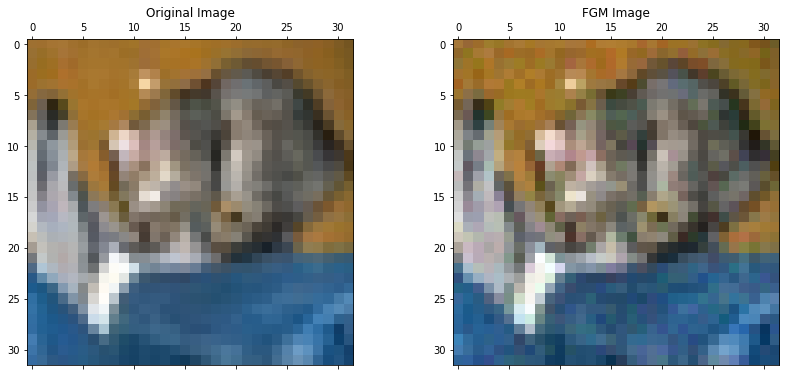

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
axes[0].matshow(X_test[0])
axes[0].set_title("Original Image")
axes[1].matshow(x_test_adv_rez2[0])
axes[1].set_title("FGM Image")

Можно заметить, что Accuracy значительно снизилась, при этом искажения изображения не столь существенны для глаза.

--------------------------------


**PGD**

In [ ]:
X3_test, Y3_test = X_test, Y_test

In [ ]:
te = time.time() 
epsa = 0.03


attack_pgd = ProjectedGradientDescent(estimator = classifier, eps = epsa, eps_step = 0.01)
x_test_adv3 = (attack_pgd.generate(X3_test))
x_test_adv_rez3 = x_test_adv3

vrem = time.time() -te

PGD - Random Initializations:   0%|          | 0/1 [00:01<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
loss_test, accuracy_test = model.evaluate(x_test_adv_rez3, Y3_test)
print('Accuracy on adversarial test data: {:4.3f}'.format(accuracy_test))
print('Lead time: {:4.2f}'.format(vrem))

Accuracy on adversarial test data: 0.145
Lead time: 1260.74


Text(0.5, 1.05, 'PGD Image')

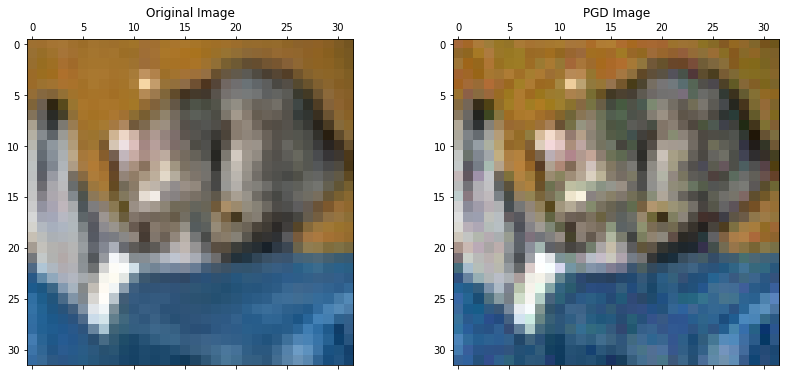

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
axes[0].matshow(X_test[0])
axes[0].set_title("Original Image")
axes[1].matshow(x_test_adv_rez3[0])
axes[1].set_title("PGD Image")

_______________


**JSMA**

In [ ]:
X4_test, Y4_test = X_test, Y_test

In [ ]:
te = time.time() 
epsa = 0.03


attack_JSMA = SaliencyMapMethod(classifier = classifier)
x_test_adv4 = (attack_JSMA.generate(X4_test))
x_test_adv_rez4 = x_test_adv4

vrem = time.time() -te

JSMA: 100%|██████████| 2000/2000 [20:46<00:00,  1.60it/s]


In [ ]:
loss_test, accuracy_test = model.evaluate(x_test_adv_rez4, Y4_test)
print('Accuracy on adversarial test data: {:4.3f}'.format(accuracy_test))
print('Lead time: {:4.2f}'.format(vrem))

Accuracy on adversarial test data: 0.045
Lead time: 1260.74


Text(0.5, 1.05, 'JSMA Image')

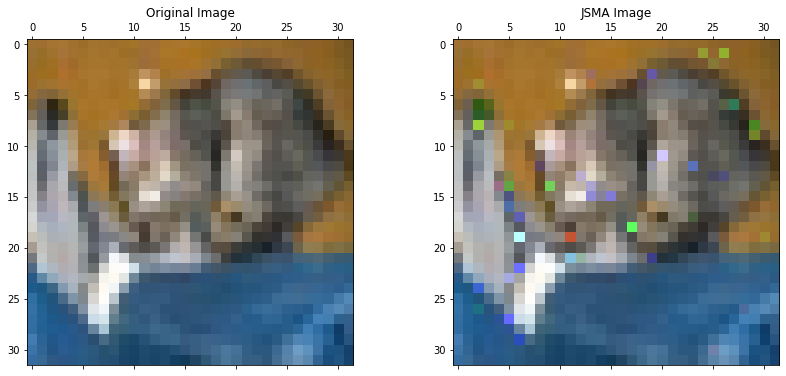

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
axes[0].matshow(X_test[0])
axes[0].set_title("Original Image")
axes[1].matshow(x_test_adv_rez4[0])
axes[1].set_title("JSMA Image")

Метод JSMA в данном случае дает самое значительное падение уровня Accuracy, однако и производимые искажения несколько более очевидны для человеческого глаза.

______________________